In [1]:
# Restart the kernel
import os
current_dir ='../../../'
os.chdir(current_dir)

In [2]:
from src.codes.basic import *
from src.codes.utils import *
import src.codes.utils as utils

from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
import src.codes.algorithms.deim as deim_module
from importlib import reload


### class for data (geometry, material property, mesh)

In [3]:
nref= [10,2]
L = [20,25]
mat_layout = np.zeros((5,2),dtype=int)
src_layout = np.zeros((5,2),dtype=int)

In [4]:
fdict = {}

cond_list = []
cond_list.append( lambda T,mu: mu*T + 100. + 0.*T )
fdict["cond"] = cond_list

dcond_list = []
dcond_list.append( lambda T,mu: mu + 0. + 0.*T )
fdict["dcond"] = dcond_list

qext_list = []
qext_list.append( lambda T,mu: 100.0 + 0.0*T )
fdict["qext"] = qext_list

dqext_list = []
dqext_list.append( lambda T,mu: 0.0 + 0.*T)
fdict["dqext"] = dqext_list

In [5]:
bc = {}
bc['x_min']={'type':'dirichlet','value':10.0}
bc['x_max']={'type':'dirichlet','value':10.0}
bc['y_min']={'type':'dirichlet','value':10.0}
bc['y_max']={'type':'refl','value':np.nan}

### Simulate FOS

In [6]:
random.seed(25)
params = np.r_[1.:4.0:0.01]
quad_deg = 3
N_snap = 15 # Training Snapshots
NL_solutions = []
param_list = []
# 


 Snap 0 


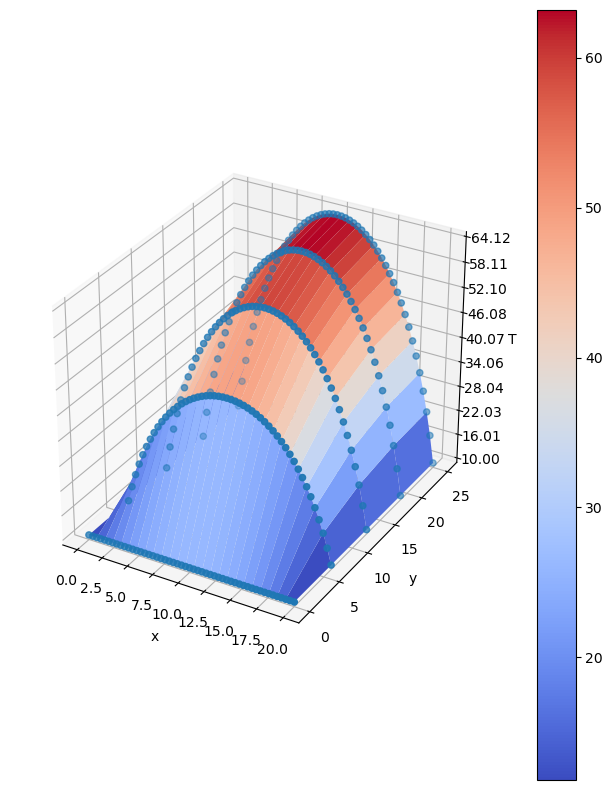


 Snap 1 


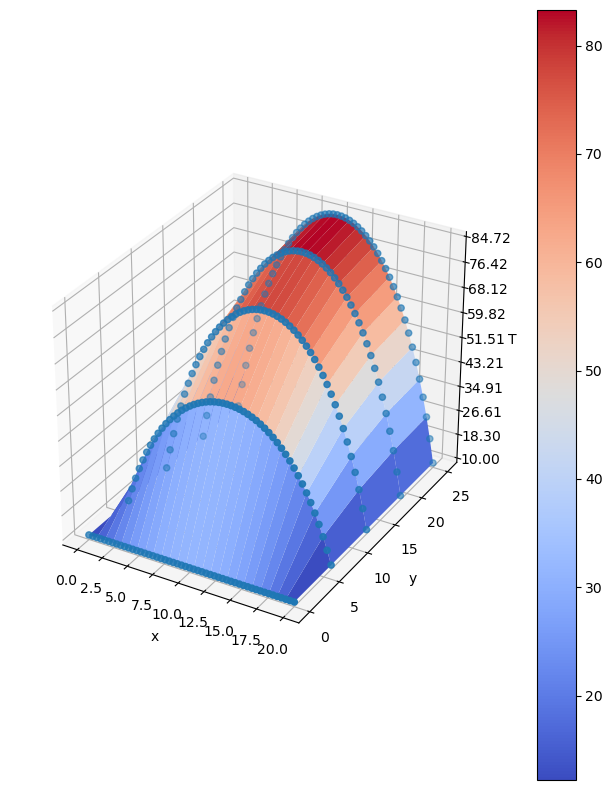


 Snap 2 


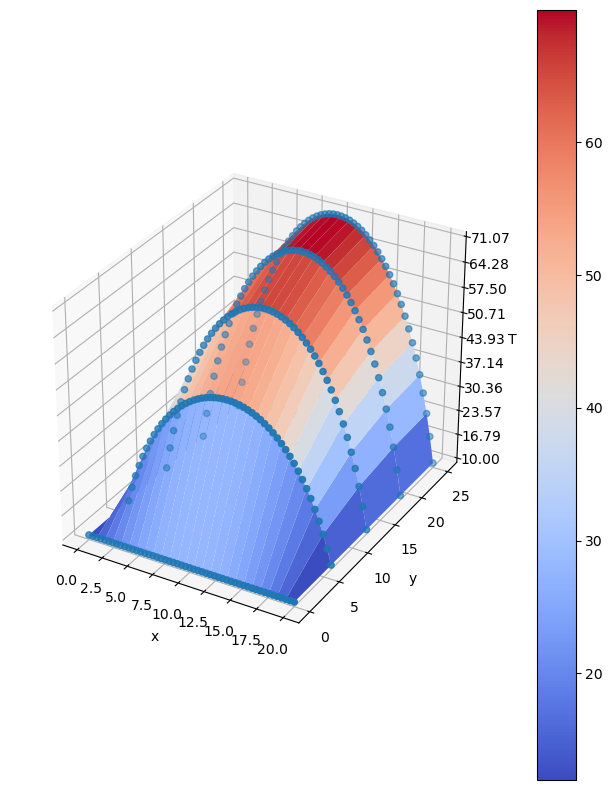


 Snap 3 

 Snap 4 

 Snap 5 

 Snap 6 

 Snap 7 

 Snap 8 

 Snap 9 

 Snap 10 

 Snap 11 

 Snap 12 

 Snap 13 

 Snap 14 


In [7]:
for i in range(N_snap):
    print(f"\n Snap {i} ")
    param = random.choice(params) # Choose from parameter list
    param_list.append(param)
    
    if i==0:
        d = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=2)
        FOS = FOS_FEM(d,quad_deg)
    else:
        FOS.mu = param
    T_init = np.zeros(d.n_verts) + 4.0
    NL_solution_p, Ke, rhs_e, mask = solve_fos(FOS, T_init)
    NL_solutions.append(NL_solution_p.flatten())

    if i<3:
        plot2D(d.xi[0], d.xi[1], NL_solution_p)

In [8]:
NLS = np.asarray(NL_solutions)
np.shape(NLS)

(15, 255)

### DEIM Hyper-reduction

#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

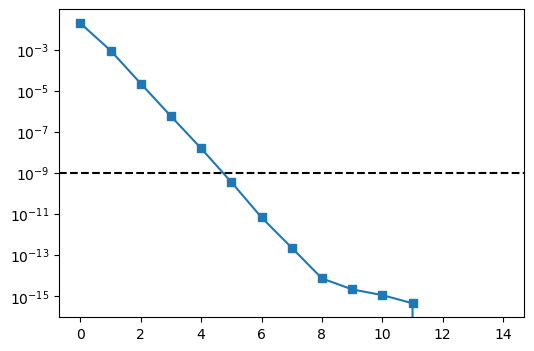

In [9]:
n_sel, U = svd_mode_selector(NL_solutions, tol_f=1e-9)
V_sel = U[:, :n_sel]

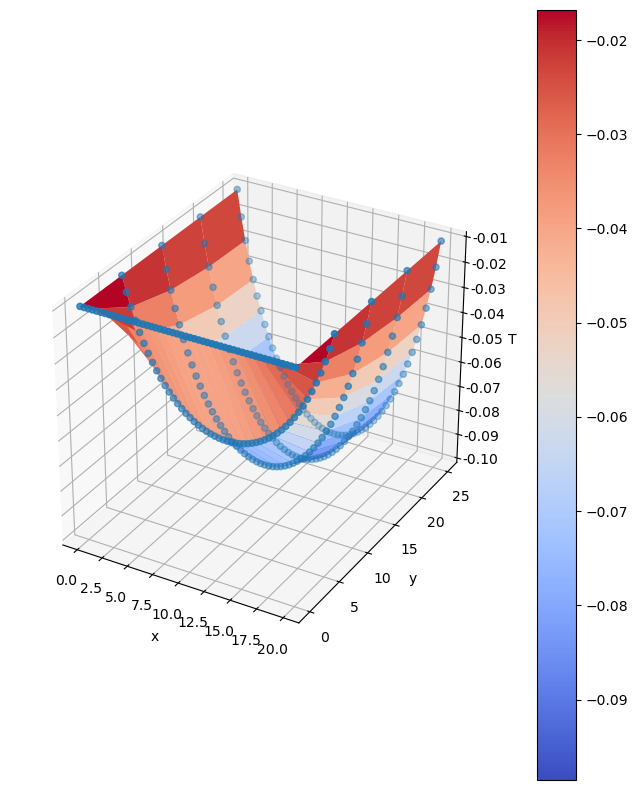

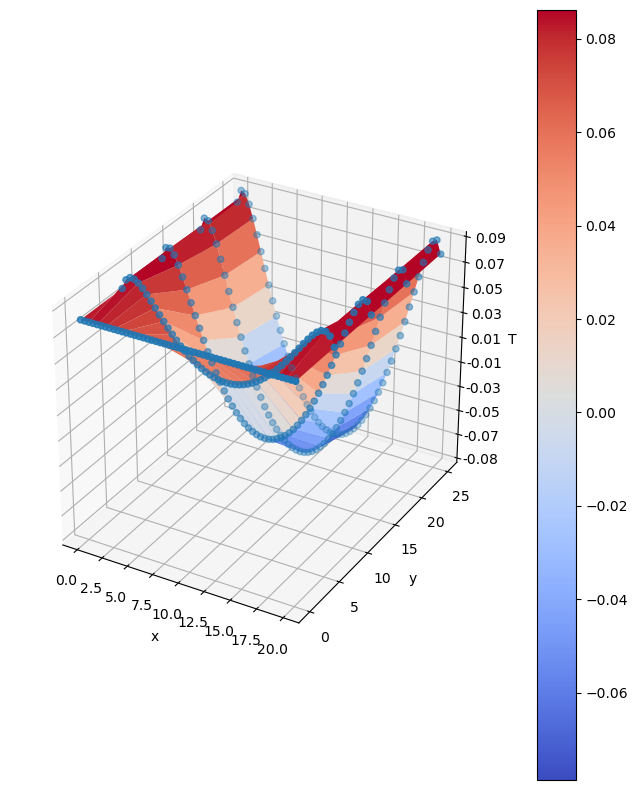

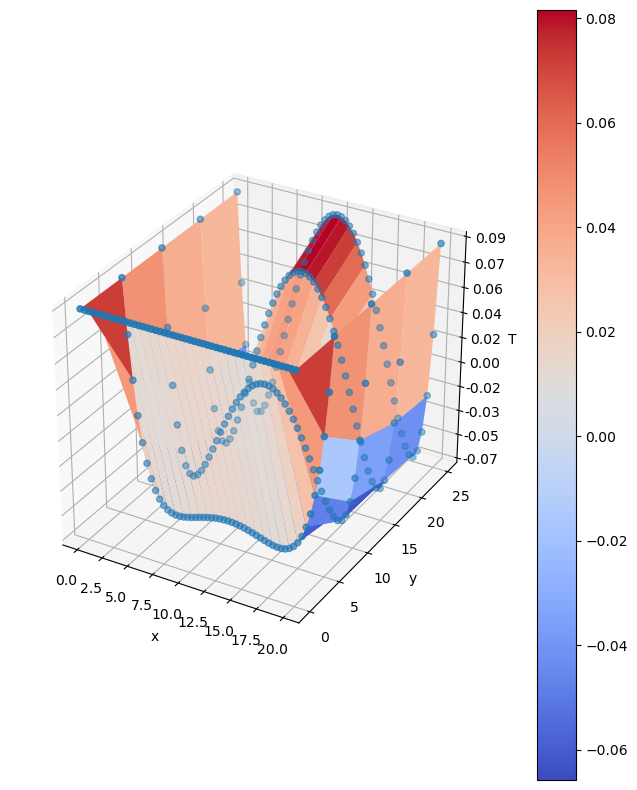

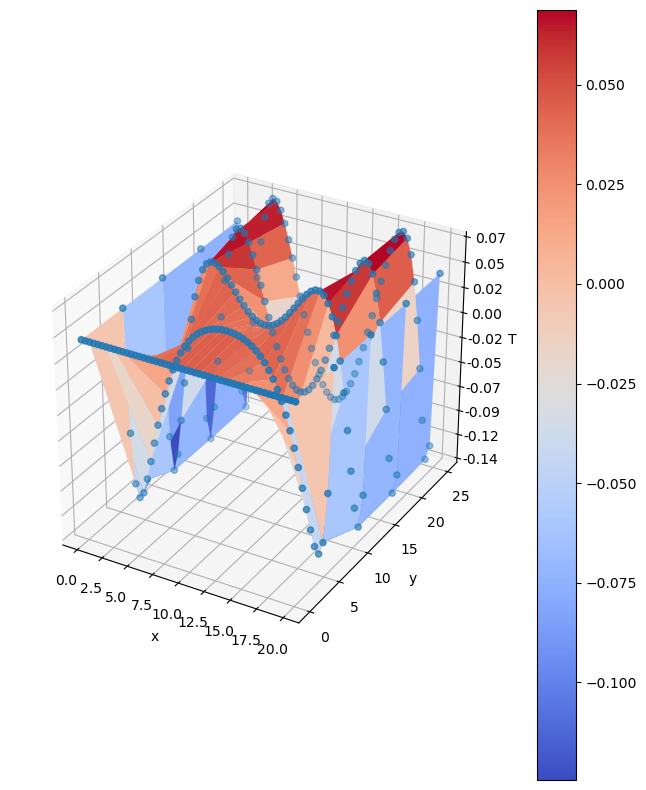

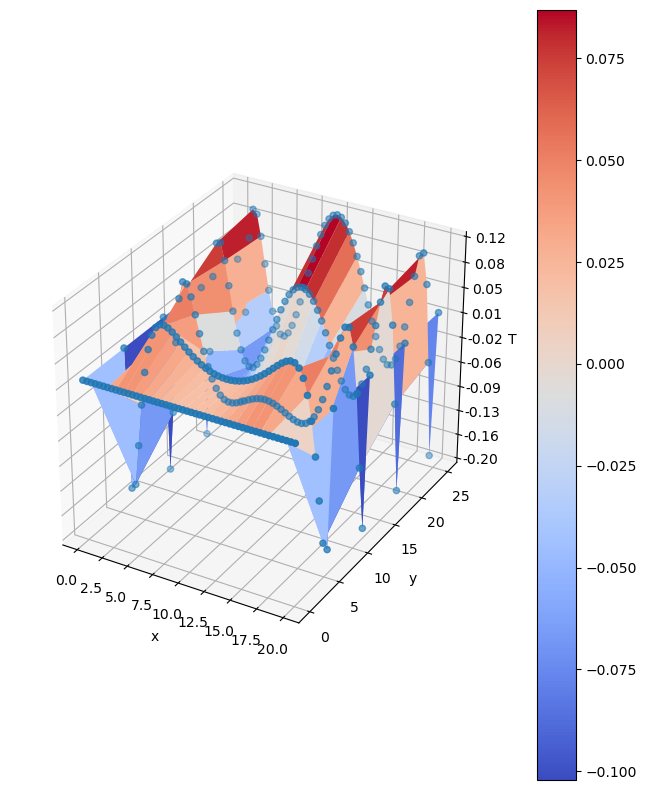

In [10]:
for i in range(n_sel):
    plot2D(d.xi[0], d.xi[1], V_sel[:,i])

### Step 2: Perform SVD on the force snapshots

In [11]:
deim = deim_module.deim(FOS,V_sel,NLS,mask,tol_f=1e-13)

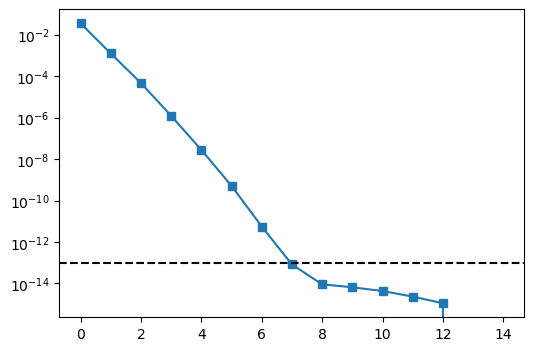

In [12]:
tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()

In [13]:
xi = deim.xi

colors = ['red' if value > 0 else 'blue' for value in xi]
sizes = [15 if value > 0 else 1 for value in xi]

print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")

Fraction of total elements active in the ROM: 12.0%


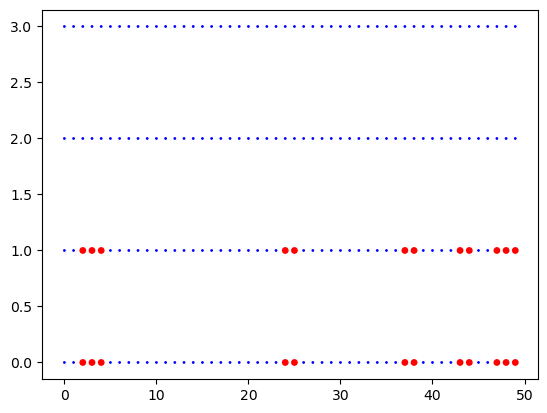

In [14]:
# reload(utils) utils.plot2D

plot2D(np.arange(d.ncells[0]),np.arange(d.ncells[1]), xi, scattr=True, clr=colors, sz=sizes)


### ROM Simulation

In [15]:
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [16]:
# Define the data-class

d_test = probdata(bc, mat_layout, src_layout, fdict, nref, L, param, pb_dim=2)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

In [17]:
# Initial guess

T_init_fos = np.zeros(FOS_test.n_nodes) + 50.0
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [18]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_p_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
toc_fos = time.time()

In [19]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_p_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [20]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_p_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
toc_rom = time.time()

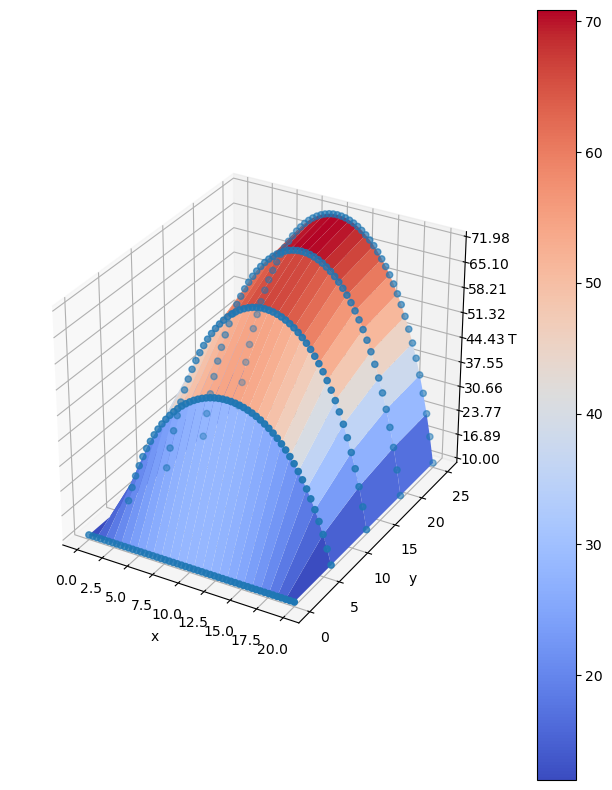

RMS_error is 0.001171574492521881 %


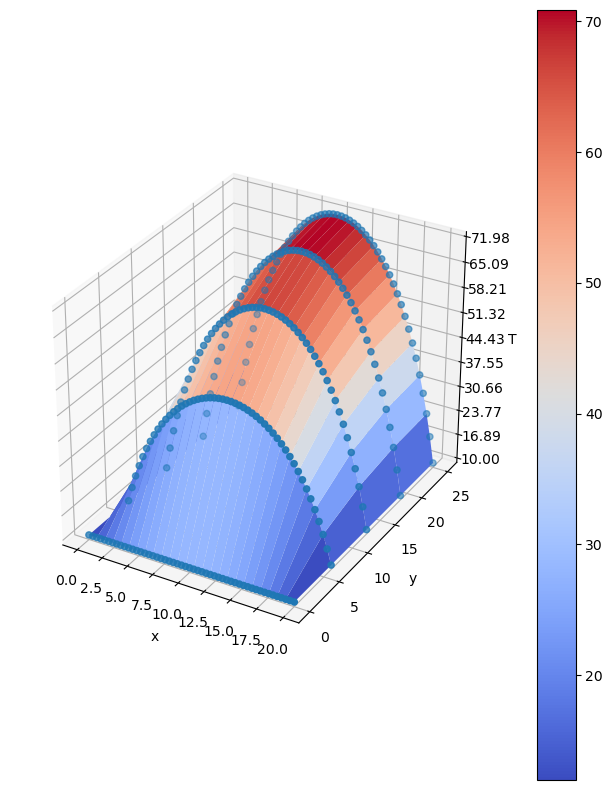



ROM Error without hyperreduction is 3.946923339127463e-06 %


In [21]:
sol_red = V_sel@NL_solution_p_reduced.reshape(-1,1)  #+pca.mean_.reshape(-1,1)
plot2D(d_test.xi[0], d_test.xi[1], sol_red)

print(f"RMS_error is {np.linalg.norm(sol_red-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")
plot2D(d_test.xi[0], d_test.xi[1], NL_solution_p_fos_test)

print(f"\n\nROM Error without hyperreduction is {np.linalg.norm(V_sel@NL_solution_p_reduced_woh.reshape(-1,1)-NL_solution_p_fos_test.reshape(-1,1))*100/np.linalg.norm(NL_solution_p_fos_test.reshape(-1,1))} %")


#### Speedups

In [22]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [23]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.7748191878675034
speedup with hyperreduction:5.3021092738197355
